# Purpose:

2015-02-05 (Thursday)

Provide a way to detect SNP-pairs of a specific distance that are outliers with regard to higher/lower $r^2$ than other SNP-pairs of the same distance.

# Process outline:
1. for each group of SNPs $x$ bp apart: collect $r^2$ from $\pm \sim5$ bp distance window around $x$:  
    a. across genome
    b. across scaffold
2. calculate modified z-score (based on _median absolute deviation_ rather than standard deviation: __MAD is more robust than SD for HTS-type data__)
3. flag any SNP-pair with $z \geq 3.5$
4. possibly randomize data and calculate FDR to evaluate performance.
    a. perhaps vary the window-size from step 1 to use FDR to chose window-size that minimizes FDR.

# Implementation:

## Imports:

In [1]:
# plotting imports
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import ggplot as gp

In [23]:
import numpy as np
import pandas as pd
import scipy
from scikits import bootstrap as bs
import statsmodels.api as sm

import munch

## File paths:

In [3]:
# define paths to files
ld_table = "/home/gus/remote_mounts/louise/data/genomes/glossina_fuscipes/annotations/SNPs/plink_out/tsetseFINAL_14Oct2014_f2_53.recode.renamed_scaffolds.maf0_05.vcf/ld/r_none_freqs_dprime.ld"


In [4]:
ld = pd.read_table(ld_table, sep=" +")
ld['R2'] = ld.R**2
ld['BP_DELTA'] = abs(ld.BP_A - ld.BP_B)

/home/gus/.virtualenvs/py279/lib/python2.7/site-packages/pandas/io/parsers.py:639: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  ParserWarning)


In [5]:
ld.head()

,CHR_A,BP_A,SNP_A,MAF_A,CHR_B,BP_B,SNP_B,MAF_B,R,DP,R2,BP_DELTA
0,Scaffold0,13388,.,0.278846,Scaffold0,23408,.,0.298077,1.000000,1,1.000000,10020
1,Scaffold0,13388,.,0.278846,Scaffold0,23418,.,0.298077,1.000000,1,1.000000,10030
2,Scaffold0,13388,.,0.278846,Scaffold0,23421,.,0.298077,1.000000,1,1.000000,10033
3,Scaffold0,13388,.,0.278846,Scaffold0,23431,.,0.288462,0.975946,1,0.952471,10043
4,Scaffold0,13388,.,0.278846,Scaffold0,30544,.,0.094340,0.464238,1,0.215517,17156


# Functions based on `2015-01-28_Plot_PLINK_results_cumulative.ipynb`

In [6]:
def get_snps_with_same_distance(df, d, win=100):
    lbound = d - win
    rbound = d + win
    
    if lbound < 0:
        lbound = 0
    
    return df[(df.BP_DELTA >= lbound) & (df.BP_DELTA <= rbound)]

In [36]:
def get_snps_grouped_by_distances(df, ds, win=100):
    assert isinstance(ds, list)
    assert all([isinstance(d, int) for d in ds])
    
    groups = {}
    
    for d in ds:
        groups[d] = get_snps_with_same_distance(df=df, d=d, win=win)
        
    return groups

In [7]:
def collect_window_stat(df, upper_lim=1000, win=10,
                        stat_name="window_mean_r2", stat_func=np.mean,
                        return_df=True
                       ):
    
    
    data = {stat_name: [], 
            'd': np.array(range(upper_lim))+1}

    
    for d  in data['d']:
        data[stat_name].append(stat_func(get_snps_with_same_distance(df=df, d=d-1, win=win).R2))

    if return_df:
        return pd.DataFrame(data)
    else:
        return data

# Explore data a bit more

In [8]:
snps = get_snps_with_same_distance(df=ld, d=1000, win=0)
snps.head()

,CHR_A,BP_A,SNP_A,MAF_A,CHR_B,BP_B,SNP_B,MAF_B,R,DP,R2,BP_DELTA
157887,Scaffold48,467632,.,0.076923,Scaffold48,468632,.,0.103774,-0.099281,1.000000,0.009857,1000
184881,Scaffold117,281622,.,0.405660,Scaffold117,282622,.,0.414894,0.708485,0.740488,0.501951,1000
220859,Scaffold334,125425,.,0.075472,Scaffold334,126425,.,0.117647,-0.106525,1.000000,0.011348,1000
258721,Scaffold1,1713984,.,0.100000,Scaffold1,1714984,.,0.396226,-0.304911,1.000000,0.092971,1000
265848,Scaffold3,2182147,.,0.490566,Scaffold3,2183147,.,0.229167,0.021497,0.038612,0.000462,1000


In [9]:
len(snps)

19

## How many members does each distance group have?

In [10]:
members_per_distance = collect_window_stat(df=ld, upper_lim=1000, win=1,
                                           stat_name="window_members", stat_func=len)

In [11]:
members_per_distance.head()

,d,window_members
0,1,2091
1,2,3631
2,3,5056
3,4,4241
4,5,4040


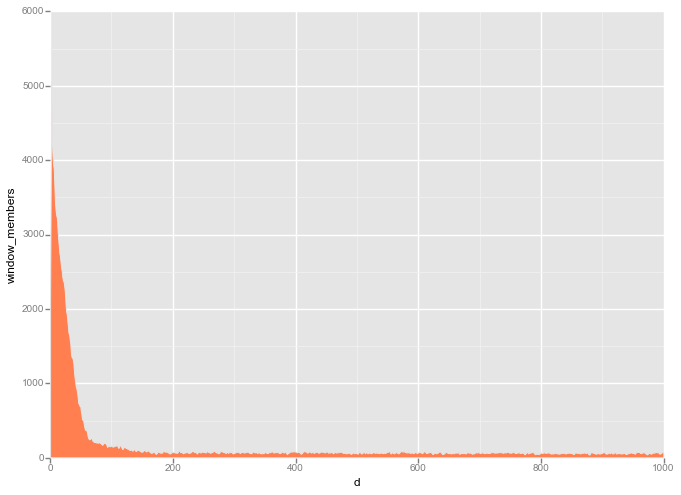

<ggplot: (8749838805793)>

In [12]:
gp.ggplot(gp.aes(x='d', y='window_members', ymin=0, ymax='window_members'), data=members_per_distance) \
+ gp.geom_area(fill='coral') #+ gp.geom_point(color='lightblue') 

In [13]:
# def bootstrap_choose(X, n=None):
#     """ Bootstrap resample an array_like
#     Parameters
#     ----------
#     X : array_like
#       data to resample
#     n : int, optional
#       length of resampled array, equal to len(X) if n==None
#     Results
#     -------
#     returns X_choices
#     """
#     if n == None:
#         n = len(X)
        
#     choice_i = np.floor(np.random.rand(n)*len(X)).astype(int)
#     X_choices = X[choice_i]
#     return X_choices

# def get_bootstrap_population(X, n=None):
#     pass

def bootstrap(data, num_samples, statistic, alpha):
    """Returns bootstrap estimate of 100.0*(1-alpha) CI for statistic."""
    n = len(data)
    idx = np.random.randint(0, n, (num_samples, n))
    samples = data[idx]
    stat = np.sort(statistic(samples, 1))
    return (stat[int((alpha/2.0)*num_samples)],
            stat[int((1-alpha/2.0)*num_samples)])

In [37]:
snp_groups_by_distance = get_snps_grouped_by_distances(df=ld, ds=[1,10,100,1000,10000,100000], win=1)

In [39]:
snp_groups_by_distance[1].BP_DELTA

126     1
387     2
1242    1
1386    1
1413    1
1764    2
2160    1
2304    2
2457    1
2637    2
2781    1
2952    2
3366    1
3438    1
3708    1
...
605066    1
605339    2
605350    1
605360    1
605601    1
605670    2
605683    2
605788    1
605791    1
605792    2
605793    1
605838    2
606168    2
606246    2
606393    1
Name: BP_DELTA, Length: 3631, dtype: int64

## How do bootstrap confidence intervals change as distance increases and member numbers decrease?

In [49]:
def get_med_mad_R2_data_for_1_group(df, distance):
    mm_data = munch.Munch()
    
    mm_data.distance = distance
    
    mm_data.med = df.R2.median()
    mm_data.mad = sm.robust.mad(df.R2)
    
    mm_data.med_ci_l,mm_data.med_ci_h = bs.ci(data=df.R2,
                                              statfunction=np.median,
                                              alpha=0.05,
                                              n_samples=10000,
                                              method='bca',
                                              output='lowhigh',
                                              epsilon=0.001, multi=None)

    mm_data.mad_ci_l,mm_data.mad_ci_h = bs.ci(data=df.R2, 
                                              statfunction=sm.robust.mad, 
                                              alpha=0.05, 
                                              n_samples=10000, 
                                              method='bca', 
                                              output='lowhigh', 
                                              epsilon=0.001, multi=None)


    return mm_data


In [46]:
bootstrap_results_template = \
"""
DISTANCE: {dist}

MEDIAN: {median}
CI: {median_low_ci},{median_hi_ci}
RANGE(MEDIAN): {median_range}

MAD: {mad}
CI: {mad_low_ci},{mad_hi_ci}
RANGE(MAD): {mad_range}
"""

In [50]:
mm_data = get_med_mad_R2_data_for_1_group(df=snp_groups_by_distance[1],
                                          distance=1)

print bootstrap_results_template.format(dist=mm_data.distance,
                                        median=mm_data.med,
                                        median_low_ci=mm_data.med_ci_l,
                                        median_hi_ci=mm_data.med_ci_h,
                                        median_range=mm_data.med_ci_h - mm_data.med_ci_l,
                                        mad=mm_data.mad,
                                        mad_low_ci=mm_data.mad_ci_l,
                                        mad_hi_ci=mm_data.mad_ci_h,
                                        mad_range=mm_data.mad_ci_h - mm_data.mad_ci_l
                                       )


DISTANCE: 1

MEDIAN: 0.741601712569
CI: 0.646666872336,0.835714102276
RANGE(MEDIAN): 0.18904722994

MAD: 0.383101874203
CI: 0.243570636435,0.523852478946
RANGE(MAD): 0.280281842511



In [54]:
print mm_data

Munch(distance=1, mad=0.38310187420324898, mad_ci_h=0.52385247894616926, mad_ci_l=0.24357063643478705, med=0.7416017125689999, med_ci_h=0.83571410227599985, med_ci_l=0.64666687233600018)


In [53]:
mm_df = pd.DataFrame(mm_data)
mm_df

ValueError: If using all scalar values, you must pass an index

## Plot how the CIs for median and MAD change with distance

- x-axis: $d$ (distance)
- y-axis: $r^2$ (LD)

1. Convert `mm_data` to `Dataframe` and use the column headers to plot to lines with upper/lower shaded bounds.
2. `ggplot` with two line geoms and correponding fill geoms.

In [28]:
gp.ggplot(gp.aes(x='d', y='window_members', ymin=0, ymax='window_members'), data=mm_data) \
+ gp.geom_area(fill='coral') #+ gp.geom_point(color='lightblue') 


DISTANCE: 1

MEDIAN: 0.741601712569
CI: 0.646666872336,0.835714102276
RANGE(MEDIAN): 0.18904722994

MAD: 0.383101874203
CI: 0.243570636435,0.523105989285
RANGE(MAD): 0.27953535285



In [ ]:
window_members_999_95CI = bootstrap(data=np.array(med1000.window_members[999]),
                                             num_samples=10000,
                                             statistic=lambda x: x.mad(),
                                             alpha=0.05
                                            )
print med1000.window_members[999].median()
rs_med1000_window_members_999_95CI

In [ ]:
bs.